## Cycle GAN to balance imbalanced diseased leaves
Images of healthy leaves could be easily found or gathered but in the case of diseased leaves gathering, proper data becomes a bit challenging. Hence we observe an imbalance in the dataset causing undesirable model performance.
The main objective of this notebook is to demonstrate the use of cycle gan to generate diseased leaves from healthy ones. But along with that, it will also serve the purpose of balancing the dataset.

In [1]:
!pip install -q efficientnet
!pip install tf-nightly
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import pandas as pd
import numpy as np

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm import tqdm as tqdm
import gc
# Data access
#from kaggle_datasets import KaggleDatasets
#GCS_DS_PATH = KaggleDatasets().get_gcs_path()
GCS_DS_PATH = "/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7"
#GCS_DS_PATH = "/Users/sangkinam/mywork/w210/data/PlantVillage-Dataset/raw/color"

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def InitializeSession():
    tf.compat.v1.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(123)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [4]:
InitializeSession()
EPOCHS = 600
SAMPLE_LEN = 100
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

IMAGE_PATH = "/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images"
TEST_PATH = "/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
md_gan = []

In [5]:
def format_path(st):
    return GCS_DS_PATH + '/images/train/' + st + '.jpg'

In [6]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [7]:
healthy = train_data[train_data['healthy']>0]
multiple_diseases = train_data[train_data['multiple_diseases']>0]
rust = train_data[train_data['rust']>0]
scab = train_data[train_data['scab']>0]

## Visualize Distribution

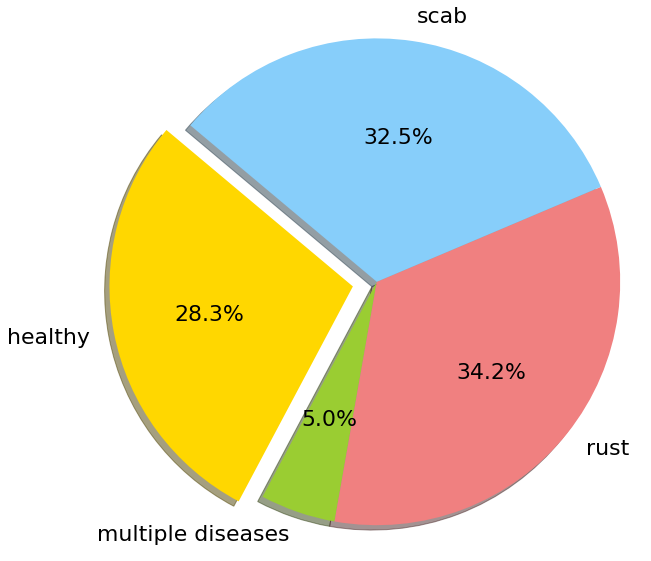

In [8]:
labels = 'healthy', 'multiple diseases', 'rust', 'scab'
sizes = [len(healthy), len(multiple_diseases), len(rust), len(scab)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

## Our objective
As we can see that the multiple disease class is imbalanced compared to other classes in the dataset. So here we would be implementing cycle gan to generate multiple diseased leaves from healthy leaves to balance the dataset.

In [9]:
def load_image(image_id, label=None, image_size=(IMG_WIDTH, IMG_HEIGHT)):
    
    if image_id.numpy().decode("utf-8").split('_')[0]=='gan' and len(image_id.numpy().decode("utf-8").split('_'))==2:
        image_id = int(image_id.numpy().decode("utf-8").split('_')[1])
        return md_gan[image_id], [0,1,0,0]
    else:        
        bits = tf.io.read_file(image_id)
        image = tf.image.decode_jpeg(bits, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, image_size)
        if label is None:
            return image
        else:
            return image, label

In [10]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [11]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [12]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [13]:
def random_jitter(image):
    # resizing to 256 x 256 x 3
    image = tf.image.resize(image, [256,256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [14]:
def preprocess_image_train(image, label):
    bits = tf.io.read_file(image)
    image = tf.image.decode_jpeg(bits, channels=3)
    
    image = random_jitter(image)
    image = normalize(image)
    return image

In [15]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [16]:
healthy_imgs = healthy.image_id.apply(format_path).values
md_imgs = multiple_diseases.image_id.apply(format_path).values

## Cycle GAN implementation

## What is Pix2Pix GAN?
Pix2Pix GAN is an algorithm for image to image translation using conditional GAN's. Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.
Link to the paper - Image-to-Image Translation with Conditional Adversarial Networks

## What is cycle GAN?
The Cycle GAN is an improved version of Pix2Pix GAN where CycleGAN works without paired examples of transformation from source to target domain, while Pix2Pix requires paired example.
The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data. CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

In [17]:
train_healthy = (
    tf.data.Dataset
    .from_tensor_slices((healthy_imgs, ['healthy_train']*len(healthy_imgs)))
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)
train_md = (
    tf.data.Dataset
    .from_tensor_slices((md_imgs, ['multiple_diseases_train']*len(md_imgs)))
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

In [22]:
print(md_imgs, train_md)

['/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_1.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_6.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_25.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_36.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_62.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_74.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_95.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_104.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_113.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_122.jpg'
 '/Users/sangkinam/mywork/w210/data/plant-pathology-2020-fgvc7/images/train/Train_128.jpg'
 '/Users

## Import and reuse the Pix2Pix models
The generatior model could also be a res-net model but for easy implementation we would be importing the pix2pix generator and discriminator where the generator is a U-net.Cyclegan uses instance normalization instead of batch normalization.



There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

- Generator G learns to transform image X to image Y.(G: X->Y)
- Generator F learns to transform image Y to image X.(F: Y->X)
- Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
- Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

In [18]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [19]:
sample_healthy = next(iter(train_healthy))
sample_md = next(iter(train_md))

In [24]:
print(type(sample_md))

<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


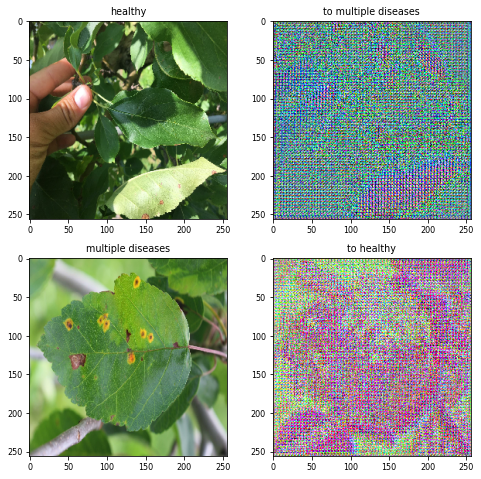

In [25]:
to_md = generator_g(sample_healthy)
to_healthy = generator_f(sample_md)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8, 8))
contrast = 8
imgs = [sample_healthy, to_md, sample_md, to_healthy]
title = ['healthy', 'to multiple diseases', 'multiple diseases', 'to healthy']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

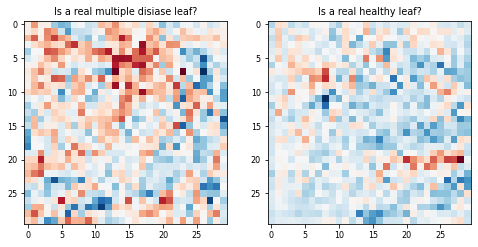

In [26]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real multiple disiase leaf?')
plt.imshow(discriminator_y(sample_md)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real healthy leaf?')
plt.imshow(discriminator_x(sample_healthy)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions
In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

## Adversarial Loss
According to the 2014 GAN model we can define the adversarial error of two mappings. For the mapping (G:X->Y) and its corresponding discriminator Dy, the loss function can be defined asIn other words, when the mapping G generates a fake but seemingly true picture G(x). The goal of the discriminator Dx is to identify the false Gx and the real y0. For the generator G its goal is opposite. The only revolutionary task is to minimize the objective function of Dx (*). (ps: Dx aims to maximize), i.e.

## Cycle Consistency Loss
Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.
In cycle consistency loss,

Image X is passed via generator G that yields generated image Y'.
Generated image Y' is passed via generator F that yields cycled image X'.
Mean absolute error is calculated between X and X'.
forward cycle consistency loss: X -> G(X) -> F(G(X) -> X'
backward cycle consistency loss: Y -> F(X) -> G(F(Y) -> Y'
The objective function is given directly below:




## Full Objective
So, we can get the total objective function as follows:

Among them is the importance of the λ used to control both losses. That is our goal:

In [27]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

In [29]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [30]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
    return LAMBDA * 0.5 * loss1

As shown above, generator G is responsible for translating image X to image Y. Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.

Identity Loss = |G(Y) - Y| + |F(X) - X|

In [31]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [32]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    generator_g = generator_g,
    generator_f = generator_f,
    discriminator_x = discriminator_x,
    discriminator_y = discriminator_y,
    generator_g_optimizer = generator_g_optimizer,
    generator_f_optimizer = generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [34]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [35]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                          discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [40]:
print(type(image_x))
print(len(image_y))

<class 'tensorflow.python.framework.ops.EagerTensor'>
1


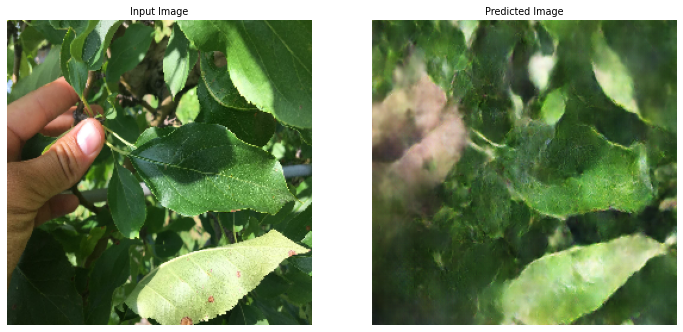

Time taken for epoch 59 is 205.50616908073425 sec

<class 'tensorflow.python.framework.ops.EagerTensor'> 1
.<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
.<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor'> 1
<class 'tensorflow.python.framework.ops.EagerTensor

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_healthy, train_md)):
        print(type(image_x), len(image_y))
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_healthy)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                              time.time()-start))
ckpt_save_path = ckpt_manager.save()
#print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                 ckpt_save_path))

## Visualize Generated Images

In [36]:
disp_img=[]
for image_ in tf.data.Dataset.zip(train_healthy):
    disp_img.append(image_)
    prediction_ = generator_g(image_)
    md_gan.append(prediction_[0].numpy() * 0.5 + 0.5)

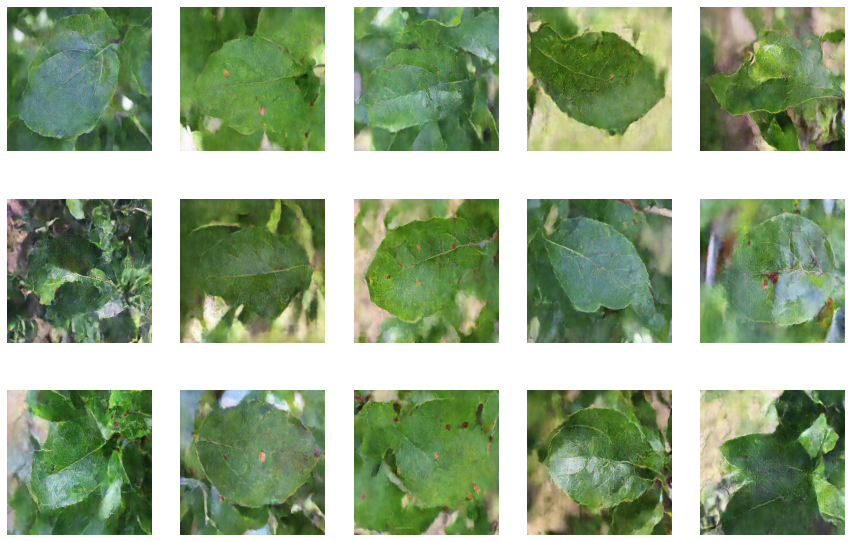

In [37]:
fig, axis =plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    # getting the pixel values between [0, 1] to plot it.
    ax.imshow(md_gan[i])
    ax.axis('off')

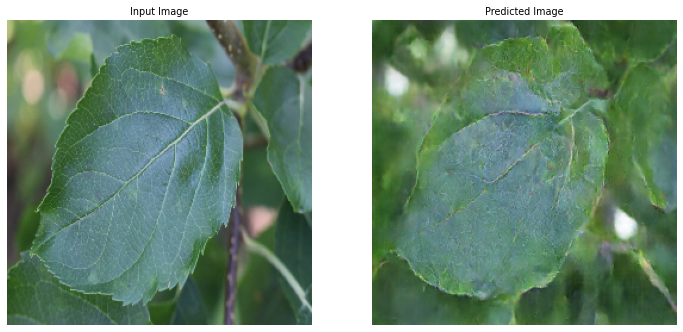

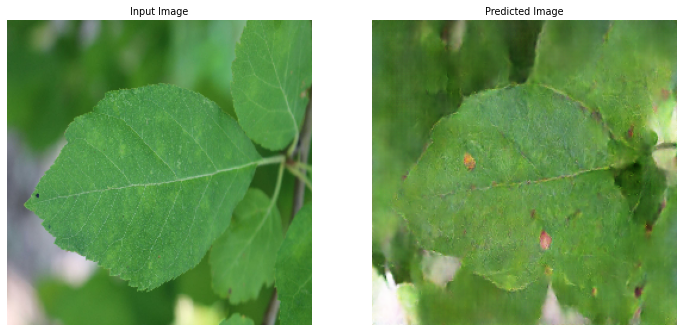

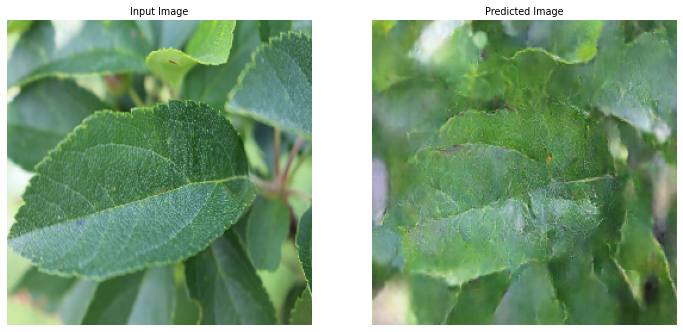

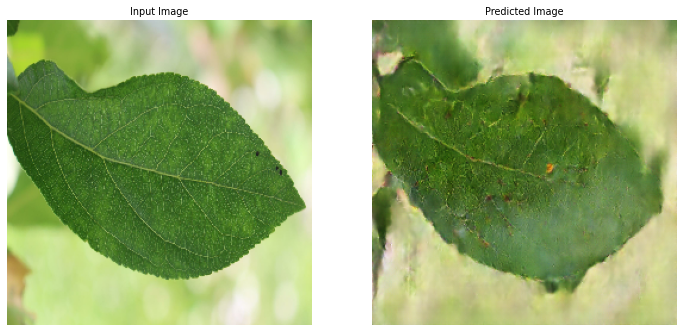

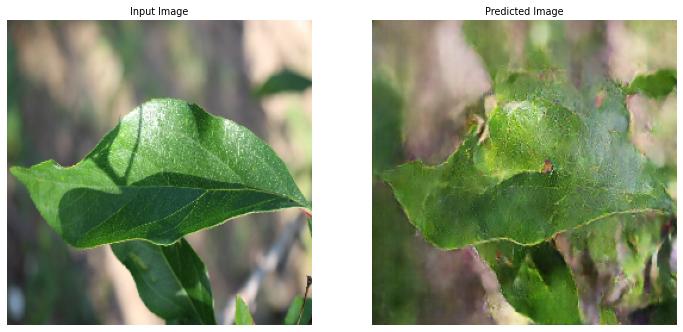

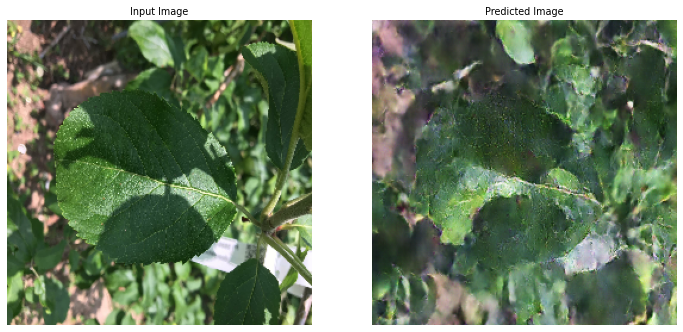

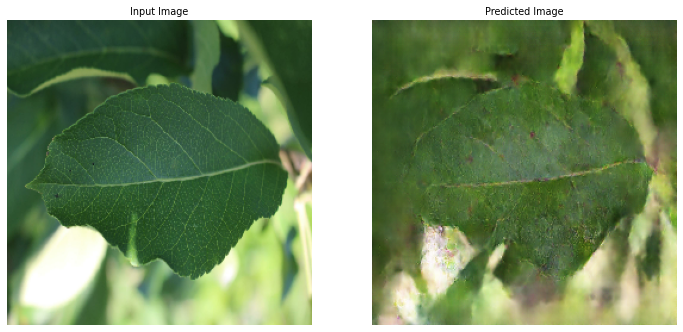

In [38]:
for i in range(7):
    generate_images(generator_g, disp_img[i])

In [39]:
del train_healthy, train_md, generator_g, generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer
del discriminator_y_optimizer, healthy, multiple_diseases, rust, scab, disp_img, generator_f,discriminator_x
del discriminator_y 
gc.collect()

82960

## Adding the generated image with the original dataset

In [ ]:
InitializeSession()
AUTO = tf.data.experimental.AUTOTUNE
gpu = tf.distribute.cluster_resolver.TFConfigClusterResolver()
tf.config.experimental_connect_to_cluster(gpu)
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
# Configuration
EPOCHS = 50
BATCH_SIZE = 10

In [ ]:
train_paths = train_data.image_id.apply(format_path).values
test_paths = train_data.image_id.apply(format_path).values
train_labels = train_data.loc[:, 'healthy':].values

train_paths = list(train_paths)
train_labels = list(train_labels)

for x in range(len(md_gan)):
    train_paths.append('gan_'+str(x))
    train_labels.append([0,1,0,0])
    
train_paths = np.asarray(train_paths)
train_labels = np.asarray(train_labels)

train_imgs, valid_imgs, train_labels, valid_labels = train_test_split(
    train_paths, 
    train_labels, 
    test_size=0.15,
    random_state=42,
)

In [ ]:
def load_image_wrapper(file, labels):
   
    return tf.py_function(load_image, [file, labels], [tf.float32, tf.int64])

In [ ]:
def build_LrFunction(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_imgs, train_labels))
    .map(load_image_wrapper, num_parallel_calls=AUTOTUNE)
    .cache()
    .map(data_augment, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
    .repeat(EPOCHS)
    .prefetch(AUTOTUNE)
)
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_imgs, valid_labels))
    .map(load_image_wrapper, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat(EPOCHS)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths,)
    .map(decode_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(256,256, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

## Note
I came across an error while fitting the model that is Out of range: End of sequence.
The problem was occurring while validating the validation dataset. I rendered the entire internet to solve this, all of them suggest to increase the size of the validation set or to create a try and except image generator function where we catch "OutofRange error" and "pass" it. I have probably tried all of them but yet the error remains. Therefore I have removed the validation data while training the model. I hope you would find a solution to correct this error.

In [ ]:
lrfn = build_LrFunction()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset.as_numpy_iterator(), 
    epochs=EPOCHS, 
    callbacks=[lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=valid_dataset.as_numpy_iterator()
)

In [ ]:
def display_training_curves(training, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(20,15), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    #ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [ ]:
display_training_curves(
    history.history['loss'], 
     
    'loss', 211)
display_training_curves(
    history.history['categorical_accuracy'], 
    
    'accuracy', 212)

In [ ]:
probs = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs
sub.to_csv('submission.csv', index=False)
sub.head()